# Training Encoder Decoder Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/ML/rnn/Machine_Translation/Data/cleaned.csv")

In [ ]:
df.tail()

**Note** this data was cleaned at notebook of EDA_And_Cleaning_Text

# Prepare dataset for encoder decoder model
## Encoder:-
* Here first we will convert text into numbers
* [WordEmbedding](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/):- Then embedding is very important layer for beause it will convert the input word-`numbers into more dimension of vectors which will have semantic information words means beause of this we can know which words are similar or near to each other.`
* We will not take output of timestamps of encoder beause it will be like one to one mapping so we will just take selt states of encoder as context vector.

## Decoder:-
* First most important thing is we have to add special tokens in each target language at start SOS and EOS at end reason of this is `The length of translated sentence might not be same as other language so it is to tell model where is start and end of sentence.`
* When building model we will provide initial state of model as context vector recived from Encoder.


#### Fisrt add eos and sos tokens
* SOS = Start Of String
* EOS = End Of String

In [ ]:
df.Marathi = df.Marathi.apply(lambda x: 'sos '+ x +' eos')

### create vocabulary of english and marathi words 

In [ ]:
eng_vocab= set()
for sent in df.English:
    for word in sent.split():
        if word not in eng_vocab:
            eng_vocab.add(word)

In [ ]:
mar_vocab= set()
for sent in df.Marathi:
    for word in sent.split():
        if word not in mar_vocab:
            mar_vocab.add(word)

In [ ]:
len(eng_vocab), len(mar_vocab), 

In [ ]:
# for zero padding add 1 in them
ENG_VOCAB_SIZE= len(eng_vocab)+1
MAR_VOCAB_SIZE= len(mar_vocab)+1
print(ENG_VOCAB_SIZE)
print(MAR_VOCAB_SIZE)


### Create dictionary for words and their indexes then we can convert text into numbers

#### First we need sorted words list

In [ ]:
eng_words = sorted(list(eng_vocab))
mar_words = sorted(list(mar_vocab))

#### Word to number

In [ ]:
# create english and marathi dicts
eng_word_index = dict((w, i) for i, w in enumerate(eng_words))
mar_word_index = dict((w, i) for i, w in enumerate(mar_words))

In [ ]:
mar_word_index

#### Number to word
*  we will need this one at time of creating text from predicted values

In [ ]:
eng_index_word = dict((i, w) for i, w in enumerate(eng_words))
mar_index_word = dict((i,w) for i, w in enumerate(mar_words))

In [ ]:
mar_index_word

### Train test split

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(df.English, df.Marathi, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Create data generator 
* if we create array of 3d shape with our vocab size this will give us out of memmory error 
* And it is always best to use batches to train it will make process faster 
* Insted of passing all data in model which may run out of memory we create data generator which will create data batches at time of training

#### prepare input for encoder decoder [refer](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
* Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:
>* encoder_input_data is a 3D array of shape (num_pairs,max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.
>* decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.
>* decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
* 2) Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.
* 3) Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

* We use a technique called “Teacher Forcing” wherein the input at each time step is given as the actual output (and not the predicted output) from the previous time step.

#### Before we go ahead lets define some things we need for data generator 

In [ ]:
### Get lengths of each sentence in list
eng_len_list=df.English.apply(lambda x: len(x.split())).to_list()

mar_len_list=df.Marathi.apply(lambda x: len(x.split())).to_list()


In [ ]:
# get max length 
np.max(mar_len_list), np.max(eng_len_list)

In [ ]:
BATCH_SIZE= 64
max_eng_len =  np.max(eng_len_list)
max_mar_len =  np.max(mar_len_list)

In [ ]:
max_eng_len, max_mar_len

## Get data generator fuction from [keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) team
* also visit [here](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) to see how keras created this input's for encoder and decoder

In [ ]:
def data_batch_generator(x, y, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, len(x), batch_size):
            encoder_input_data = np.zeros((batch_size,max_eng_len ), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_mar_len), dtype='float32')
            # one hot encoded target data beause dense layer with softmax will give only one output at a time
            decoder_target_data = np.zeros((batch_size, max_mar_len, MAR_VOCAB_SIZE), dtype='float32' )
            for j, (eng_text, mar_text) in enumerate(zip(x[i:i+batch_size], y[i:i+batch_size])):
                for t , word in enumerate(eng_text.split()):
                    encoder_input_data[j,t] = eng_word_index[word]
                for t, word in enumerate(mar_text.split()):
                    if t < len(mar_text.split()) - 1:
                        decoder_input_data[j,t]= mar_word_index[word]
                    if t>0:
                        # This is decoder target output which is one step ahead of decoder input 
                        # it does not have EOS token 
                        decoder_target_data[j,t-1, mar_word_index[word]] = 1.
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)      
            

# LSTM Encoder Decoder Model

In [2]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model

In [ ]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,100, mask_zero=True)(encoder_input)
encoder_lstm = LSTM(100, return_state=True)
encoder_output,state_h, state_c = encoder_lstm(encoder_embd)

## Now take only states and create context vector
encoder_states= [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 100, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
decoder_lstm = LSTM(100, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model1 = Model([encoder_input, decoder_input], decoder_outputs)

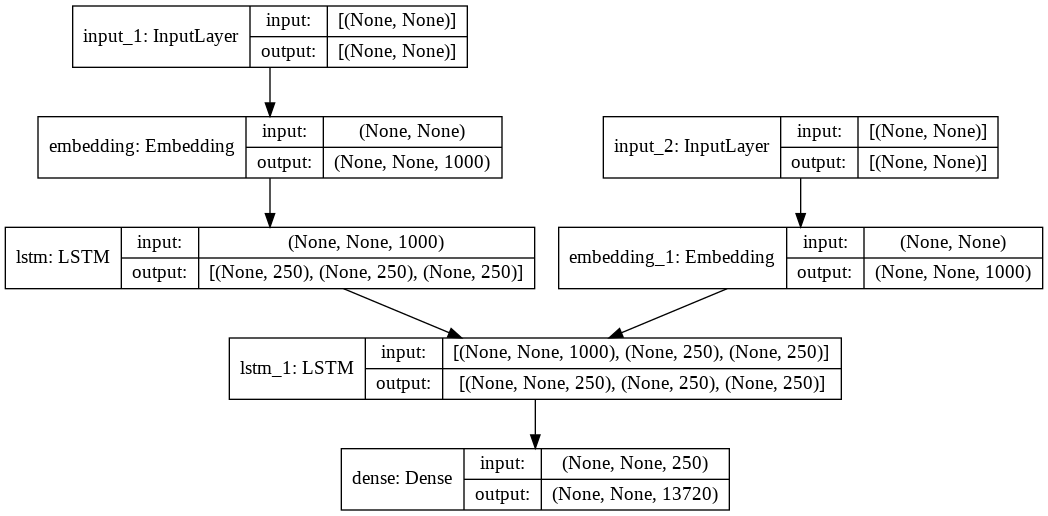

In [ ]:
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
plot_model(model2,show_shapes=True)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

#### **IMP NOTE** - here to avoid unknown samples need to use sptes per epoch else model will fit for infinite samples

In [ ]:
steps_per_epoch= np.ceil(len(X_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(X_train)/BATCH_SIZE)

In [ ]:
steps_per_epoch

577.0

In [ ]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }
EPOCHS

30

In [ ]:
history1= model1.fit(data_batch_generator(X_train,y_train), 
                       epochs=EPOCHS,
                       steps_per_epoch= steps_per_epoch,
                     validation_data=data_batch_generator(X_test, y_test, BATCH_SIZE),
                       validation_steps=steps_per_epoch_val,
                     callbacks=callbacks_list)

Epoch 1/30
577/577 [==============================] - 198s 330ms/step - loss: 0.9354 - accuracy: 0.1949 - val_loss: 0.8403 - val_accuracy: 0.2166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 2/30
577/577 [==============================] - 188s 326ms/step - loss: 0.7959 - accuracy: 0.2496 - val_loss: 0.7654 - val_accuracy: 0.2647


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 3/30
577/577 [==============================] - 188s 326ms/step - loss: 0.7099 - accuracy: 0.3004 - val_loss: 0.6960 - val_accuracy: 0.3211


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 4/30
577/577 [==============================] - 188s 326ms/step - loss: 0.6342 - accuracy: 0.3508 - val_loss: 0.6417 - val_accuracy: 0.3633


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 5/30
577/577 [==============================] - 187s 325ms/step - loss: 0.5699 - accuracy: 0.3917 - val_loss: 0.5976 - val_accuracy: 0.3923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 6/30
577/577 [==============================] - 186s 322ms/step - loss: 0.5136 - accuracy: 0.4275 - val_loss: 0.5598 - val_accuracy: 0.4202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 7/30
577/577 [==============================] - 187s 325ms/step - loss: 0.4632 - accuracy: 0.4615 - val_loss: 0.5295 - val_accuracy: 0.4434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 8/30
577/577 [==============================] - 186s 323ms/step - loss: 0.4178 - accuracy: 0.4960 - val_loss: 0.5017 - val_accuracy: 0.4673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 9/30
577/577 [==============================] - 186s 323ms/step - loss: 0.3774 - accuracy: 0.5291 - val_loss: 0.4798 - val_accuracy: 0.4864


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 10/30
577/577 [==============================] - 187s 323ms/step - loss: 0.3413 - accuracy: 0.5606 - val_loss: 0.4619 - val_accuracy: 0.5022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 11/30
577/577 [==============================] - 186s 322ms/step - loss: 0.3086 - accuracy: 0.5906 - val_loss: 0.4458 - val_accuracy: 0.5159


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 12/30
577/577 [==============================] - 187s 324ms/step - loss: 0.2813 - accuracy: 0.6173 - val_loss: 0.4335 - val_accuracy: 0.5287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 13/30
577/577 [==============================] - 187s 324ms/step - loss: 0.2535 - accuracy: 0.6464 - val_loss: 0.4219 - val_accuracy: 0.5375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 14/30
577/577 [==============================] - 186s 323ms/step - loss: 0.2295 - accuracy: 0.6739 - val_loss: 0.4125 - val_accuracy: 0.5499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 15/30
577/577 [==============================] - 187s 324ms/step - loss: 0.2084 - accuracy: 0.6996 - val_loss: 0.4046 - val_accuracy: 0.5586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 16/30
577/577 [==============================] - 187s 325ms/step - loss: 0.1896 - accuracy: 0.7235 - val_loss: 0.4007 - val_accuracy: 0.5657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 17/30
577/577 [==============================] - 188s 326ms/step - loss: 0.1727 - accuracy: 0.7453 - val_loss: 0.3940 - val_accuracy: 0.5744


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 18/30
577/577 [==============================] - 186s 323ms/step - loss: 0.1584 - accuracy: 0.7632 - val_loss: 0.3896 - val_accuracy: 0.5799


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 19/30
577/577 [==============================] - 191s 331ms/step - loss: 0.1450 - accuracy: 0.7800 - val_loss: 0.3878 - val_accuracy: 0.5839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 20/30
577/577 [==============================] - 188s 326ms/step - loss: 0.1337 - accuracy: 0.7934 - val_loss: 0.3844 - val_accuracy: 0.5901


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 21/30
577/577 [==============================] - 186s 323ms/step - loss: 0.1234 - accuracy: 0.8055 - val_loss: 0.3827 - val_accuracy: 0.5934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 22/30
577/577 [==============================] - 186s 322ms/step - loss: 0.1145 - accuracy: 0.8158 - val_loss: 0.3812 - val_accuracy: 0.5974


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 23/30
577/577 [==============================] - 185s 321ms/step - loss: 0.1067 - accuracy: 0.8250 - val_loss: 0.3813 - val_accuracy: 0.6006


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 24/30
577/577 [==============================] - 187s 325ms/step - loss: 0.0995 - accuracy: 0.8335 - val_loss: 0.3810 - val_accuracy: 0.6026


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 25/30
577/577 [==============================] - 185s 322ms/step - loss: 0.0928 - accuracy: 0.8422 - val_loss: 0.3826 - val_accuracy: 0.6038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 26/30
577/577 [==============================] - 186s 323ms/step - loss: 0.0871 - accuracy: 0.8483 - val_loss: 0.3827 - val_accuracy: 0.6073


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 27/30
577/577 [==============================] - 186s 322ms/step - loss: 0.0820 - accuracy: 0.8544 - val_loss: 0.3832 - val_accuracy: 0.6089


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 28/30
577/577 [==============================] - 185s 321ms/step - loss: 0.0773 - accuracy: 0.8609 - val_loss: 0.3848 - val_accuracy: 0.6121


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 29/30
577/577 [==============================] - 186s 323ms/step - loss: 0.0733 - accuracy: 0.8646 - val_loss: 0.3868 - val_accuracy: 0.6118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


Epoch 30/30
577/577 [==============================] - 186s 323ms/step - loss: 0.0693 - accuracy: 0.8698 - val_loss: 0.3887 - val_accuracy: 0.6101


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/assets


In [ ]:
model1.save_weights('/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/saved_models/model1_weights.h5')

In [ ]:
model1.load_weights('/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/saved_models/model1_weights.h5')

# Model2
Now we will try to improve its accurcy with changing some units

In [ ]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,1000, mask_zero=True)(encoder_input)
encoder_lstm = LSTM(250, return_state=True)
encoder_output,state_h, state_c = encoder_lstm(encoder_embd)

## Now take only states and create context vector
encoder_states= [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 1000, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
decoder_lstm = LSTM(250, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model2 = Model([encoder_input, decoder_input], decoder_outputs)

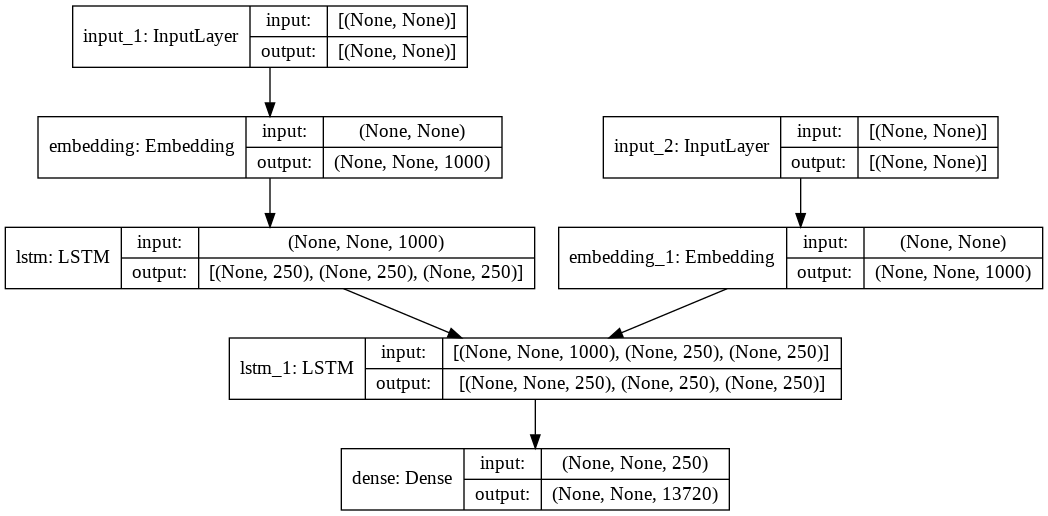

In [ ]:
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
plot_model(model2,show_shapes=True)

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
steps_per_epoch= np.ceil(len(X_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(X_train)/BATCH_SIZE)

In [ ]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }
EPOCHS

30

In [ ]:
history2= model2.fit(data_batch_generator(X_train,y_train), 
                       epochs=EPOCHS,
                       steps_per_epoch= steps_per_epoch,
                     validation_data=data_batch_generator(X_test, y_test, BATCH_SIZE),
                       validation_steps=steps_per_epoch_val,
                     callbacks=callbacks_list)

Epoch 1/30
577/577 [==============================] - 287s 485ms/step - loss: 0.8689 - accuracy: 0.2276 - val_loss: 0.7446 - val_accuracy: 0.2847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 2/30
577/577 [==============================] - 280s 485ms/step - loss: 0.6486 - accuracy: 0.3502 - val_loss: 0.5890 - val_accuracy: 0.3998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 3/30
577/577 [==============================] - 273s 474ms/step - loss: 0.4886 - accuracy: 0.4599 - val_loss: 0.4851 - val_accuracy: 0.4878


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 4/30
577/577 [==============================] - 273s 473ms/step - loss: 0.3671 - accuracy: 0.5554 - val_loss: 0.4184 - val_accuracy: 0.5457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 5/30
577/577 [==============================] - 274s 474ms/step - loss: 0.2760 - accuracy: 0.6375 - val_loss: 0.3764 - val_accuracy: 0.5818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 6/30
577/577 [==============================] - 271s 470ms/step - loss: 0.2078 - accuracy: 0.7061 - val_loss: 0.3483 - val_accuracy: 0.6097


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 7/30
577/577 [==============================] - 270s 467ms/step - loss: 0.1572 - accuracy: 0.7634 - val_loss: 0.3317 - val_accuracy: 0.6282


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 8/30
577/577 [==============================] - 272s 472ms/step - loss: 0.1201 - accuracy: 0.8117 - val_loss: 0.3223 - val_accuracy: 0.6395


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 9/30
577/577 [==============================] - 273s 473ms/step - loss: 0.0936 - accuracy: 0.8449 - val_loss: 0.3164 - val_accuracy: 0.6507


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 10/30
577/577 [==============================] - 274s 475ms/step - loss: 0.0754 - accuracy: 0.8673 - val_loss: 0.3158 - val_accuracy: 0.6541


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 11/30
577/577 [==============================] - 273s 474ms/step - loss: 0.0625 - accuracy: 0.8823 - val_loss: 0.3163 - val_accuracy: 0.6567


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 12/30
577/577 [==============================] - 272s 471ms/step - loss: 0.0534 - accuracy: 0.8931 - val_loss: 0.3187 - val_accuracy: 0.6601


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 13/30
577/577 [==============================] - 272s 471ms/step - loss: 0.0464 - accuracy: 0.9027 - val_loss: 0.3213 - val_accuracy: 0.6611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 14/30
577/577 [==============================] - 273s 473ms/step - loss: 0.0412 - accuracy: 0.9097 - val_loss: 0.3245 - val_accuracy: 0.6595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 15/30
577/577 [==============================] - 274s 476ms/step - loss: 0.0372 - accuracy: 0.9154 - val_loss: 0.3280 - val_accuracy: 0.6623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 16/30
577/577 [==============================] - 276s 478ms/step - loss: 0.0337 - accuracy: 0.9209 - val_loss: 0.3346 - val_accuracy: 0.6604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 17/30
577/577 [==============================] - 274s 476ms/step - loss: 0.0311 - accuracy: 0.9249 - val_loss: 0.3376 - val_accuracy: 0.6593


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 18/30
577/577 [==============================] - 275s 477ms/step - loss: 0.0290 - accuracy: 0.9293 - val_loss: 0.3418 - val_accuracy: 0.6586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 19/30
577/577 [==============================] - 276s 478ms/step - loss: 0.0271 - accuracy: 0.9332 - val_loss: 0.3453 - val_accuracy: 0.6579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


Epoch 20/30
577/577 [==============================] - 274s 475ms/step - loss: 0.0256 - accuracy: 0.9361 - val_loss: 0.3498 - val_accuracy: 0.6543


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/model_checkpoints/model2/assets


In [ ]:
model2.save_weights('/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/saved_models/2_model_weights.h5')

In [ ]:
model2.load_weights('/content/drive/MyDrive/rnn/machine_translation/Encoder_Decoder/saved_models/2_model_weights.h5')

## Inference model
*  As we trained our enoder decoder do same for prdiction means apply encoder on input sent and applying decoder on target sent

In [ ]:
encoder_model = Model(encoder_input, encoder_states)

In [ ]:
decoder_state_input_h = Input(shape=(250,))
decoder_state_input_c= Input(shape=(250,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

# To predict we have to encoder text first then pass than to decoder we can get predicted values

In [45]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = mar_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
test_gen= data_batch_generator(X_test,y_test,batch_size=1)


In [ ]:
Actual_test_sent = X_test.to_list()
Actual_test_trans= y_test.to_list()

In [ ]:
test_inputs=[]
test_outputs=[]

In [ ]:
from tqdm import tqdm
for (input, output),_ in tqdm(iter(test_gen)):
    test_inputs.append(input)
    test_outputs.append(output)

In [ ]:
test_inputs[0]

array([[2435., 5403.,  728., 3236., 2008.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]],
      dtype=float32)

In [ ]:
print("English Senteces:", Actual_test_sent[0])
print("Actual Marathi Sentence:", Actual_test_trans[0][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[0])[:-4])


English Senteces: i was calling my friend
Actual Marathi Sentence: sos मी माझ्या मित्राला बोलवत होतो
Predicted Marathi Translation:  मी माझ्या मैत्रिणीला बोलवत होतो


In [ ]:
print("English Senteces:", Actual_test_sent[1])
print("Actual Marathi Sentence:", Actual_test_trans[1][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[1])[:-4])


English Senteces: i like coffee
Actual Marathi Sentence: sos मला कॉफी आवडते
Predicted Marathi Translation:  मला कॉफी आवडते


In [ ]:
print("English Senteces:", Actual_test_sent[3])
print("Actual Marathi Sentence:", Actual_test_trans[3][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[3])[:-4])


English Senteces: he likes english very much
Actual Marathi Sentence: sos त्यांना इंग्रजी खूप आवडते
Predicted Marathi Translation:  त्याला इंग्रजी खूप आवडतं


In [ ]:
print("English Senteces:", Actual_test_sent[10])
print("Actual Marathi Sentence:", Actual_test_trans[10][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[10])[:-4])


English Senteces: i like cats
Actual Marathi Sentence: sos मला मांजरी आवडतात
Predicted Marathi Translation:  मला मांजरी आवडतात


In [ ]:
print("English Senteces:", Actual_test_sent[50])
print("Actual Marathi Sentence:", Actual_test_trans[50][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[50])[:-4])


English Senteces: i forgot to call tom
Actual Marathi Sentence: sos मी टॉमला फोन करायला विसरलो
Predicted Marathi Translation:  मी टॉमला फोन करायला विसरले


In [ ]:
print("English Senteces:", Actual_test_sent[100])
print("Actual Marathi Sentence:", Actual_test_trans[100][4:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[100])[:-4])


English Senteces: i did not want to stop
Actual Marathi Sentence: मला थांबायचं नव्हतं
Predicted Marathi Translation:  मला थांबायचं नाहीये


In [ ]:
print("English Senteces:", Actual_test_sent[89])
print("Actual Marathi Sentence:", Actual_test_trans[89][4:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[89])[:-4])

English Senteces: tom never tells us anything
Actual Marathi Sentence: टॉम आम्हाला कधीच काही सांगत नाही
Predicted Marathi Translation:  टॉम आपल्याला कधीच काही सांगत नाही


In [ ]:
print("English Senteces:", Actual_test_sent[77])
print("Actual Marathi Sentence:", Actual_test_trans[77][4:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[77])[:-4])


English Senteces: the rumor is going around that the actress is going to get a divorce
Actual Marathi Sentence: अशी अफवा पसरली जात आहे की ती अभिनेत्री घटस्फोट देणार आहे
Predicted Marathi Translation:  त्या फळाचा आकार संत्र्यासारखा असतो पण पुरुष जाणार


In [ ]:
print("English Senteces:", Actual_test_sent[123])
print("Actual Marathi Sentence:", Actual_test_trans[123][4:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[123])[:-4])


English Senteces: where is your baby
Actual Marathi Sentence: तुमचं बाळ कुठेय
Predicted Marathi Translation:  तुझं बाळ कुठे आहे


In [ ]:
print("English Senteces:", Actual_test_sent[165])
print("Actual Marathi Sentence:", Actual_test_trans[165][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[165])[:-4])

English Senteces: i phoned him
Actual Marathi Sentence: sos मी त्यांना फोन केला
Predicted Marathi Translation:  मी त्याला फोन केला


In [ ]:
print("English Senteces:", Actual_test_sent[177])
print("Actual Marathi Sentence:", Actual_test_trans[177][:-4])
print("Predicted Marathi Translation:", get_predicted_sentence(test_inputs[177])[:-4])

English Senteces: i do not like walking home alone after dark
Actual Marathi Sentence: sos मला काळोख झाल्यानंतर एकट्याने घरी चालत जायला आवडत नाही
Predicted Marathi Translation:  मला घरी बसून घरी चालत जायला आवडत नाही
